In [2]:
import xarray as xr
# import glob
# import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

# from google.cloud import storage
# import gcsfs
# import zarr

import xskillscore as xs
import pandas as pd

import os

# import re
# import skill_metrics as sm

# import matplotlib.lines as mlines
import seaborn as sns

from matplotlib.font_manager import FontProperties
import os

In [3]:
# results_2022_ws = xr.open_dataset('results_2022_ws.nc')
# results_2022_ws_gcshifted = xr.open_dataset('results_2022_ws_gcshifted.nc')
# results_2022_ws_gcshifted_meso = xr.open_dataset('results_2022_ws_gcshifted_meso.nc')
results = xr.open_dataset('results_2022_ens.nc')
# results_2022_ws_gcshifted['2m_temperature_gc'] == results_2022_ws_gcshifted_meso_gc['2m_temperature_gc']
results

<xarray.Dataset> Size: 164MB
Dimensions:                                    (prediction_timedelta: 16,
                                                time: 354, station: 47)
Coordinates:
  * prediction_timedelta                       (prediction_timedelta) timedelta64[ns] 128B ...
  * time                                       (time) datetime64[ns] 3kB 2022...
  * station                                    (station) <U5 940B '06201' ......
    lat                                        (station) float64 376B ...
    lon                                        (station) float64 376B ...
    valid_time                                 (time, prediction_timedelta) datetime64[ns] 45kB ...
Data variables: (12/105)
    2m_temperature_hres                        (time, prediction_timedelta, station) float32 1MB ...
    mean_sea_level_pressure_hres               (time, prediction_timedelta, station) float32 1MB ...
    10m_v_component_of_wind_hres               (time, prediction_timedelta, station) float32 1MB ...
    10m_u_component_of_wind_hres               (time, prediction_timedelta, station) float32 1MB ...
    total_precipitation_6hr_hres               (time, prediction_timedelta, station) float32 1MB ...
    2m_temperature_synop                       (time, prediction_timedelta, station) float64 2MB ...
    ...                                         ...
    mean_sea_level_pressure_hres_pangu_gc_ens  (time, prediction_timedelta, station) float64 2MB ...
    10m_wind_speed_hres_pangu_gc_ens           (time, prediction_timedelta, station) float64 2MB ...
    10m_wind_direction_hres_pangu_gc_ens       (time, prediction_timedelta, station) float64 2MB ...
    10m_v_component_of_wind_hres_pangu_gc_ens  (time, prediction_timedelta, station) float64 2MB ...
    10m_u_component_of_wind_hres_pangu_gc_ens  (time, prediction_timedelta, station) float64 2MB ...
    total_precipitation_6hr_hres_pangu_gc_ens  (time, prediction_timedelta, station) float64 2MB ...

## Supporting Functions

### Statistics functins

In [4]:
def calculate_statistic(results, statistic_method, model_suffix='hres', variable=None, date_ranges=None, by_station=False):
    """
    Calculate a statistical method (e.g., RMSE, MAE, Pearson R, Bias) between forecast and observation data.

    Parameters:
        results (xarray.Dataset): The dataset containing the forecast and observation variables.
        statistic_method (str): The statistical method to use for the calculation.
        model_suffix (str): The suffix used in the forecast variables to distinguish them (default is '_hres').
        variable (str): Specific variable to analyze. If None, analyze all variables.
        date_ranges (list of tuples): List of date ranges to filter the data. Each tuple should be (start_date, end_date).
        by_station (bool): If True, calculate the statistic separately for each station. Default is False.

    Returns:
        xarray.Dataset: A dataset containing the calculated statistical results.
    """
    # Define supported methods, including the new 'bias' method
    supported_methods = {
        'rmse': lambda forecast, obs, dim: xs.rmse(forecast, obs, dim=dim, skipna=True),
        'mae': lambda forecast, obs, dim: xs.mae(forecast, obs, dim=dim, skipna=True),
        'mse': lambda forecast, obs, dim: xs.mse(forecast, obs, dim=dim, skipna=True),
        'pearson_r': lambda forecast, obs, dim: xs.pearson_r(forecast, obs, dim=dim, skipna=True),
        'spearman_r': lambda forecast, obs, dim: xs.spearman_r(forecast, obs, dim=dim, skipna=True),
        'bias': lambda forecast, obs, dim: (forecast - obs).mean(dim=dim, skipna=True),  # Bias calculation
        'mean_absolute_percentage_error': lambda forecast, obs, dim: xs.mape(forecast, obs, dim=dim, skipna=True),
        'brier_score': lambda forecast, obs, dim: xs.brier_score(forecast, obs, dim=dim, skipna=True),
        'threshold_brier_score': lambda forecast, obs, dim: xs.threshold_brier_score(forecast, obs, dim=dim, skipna=True),
        'crps_gaussian': lambda forecast, obs, dim: xs.crps_gaussian(forecast, obs, dim=dim, skipna=True),
        'crps_quadrature': lambda forecast, obs, dim: xs.crps_quadrature(forecast, obs, dim=dim, skipna=True),
        'crps_ensemble': lambda forecast, obs, dim: xs.crps_ensemble(forecast, obs, dim=dim, skipna=True),
        'rank_histogram': lambda forecast, obs, dim: xs.rank_histogram(forecast, obs, dim=dim, skipna=True),
        'roc': lambda forecast, obs, dim: xs.roc(forecast, obs, dim=dim, skipna=True),
        'reliability': lambda forecast, obs, dim: xs.reliability(forecast, obs, dim=dim, skipna=True),
        'discrimination': lambda forecast, obs, dim: xs.discrimination(forecast, obs, dim=dim, skipna=True),
        'rps': lambda forecast, obs, dim: xs.rps(forecast, obs, dim=dim, skipna=True)
    }

    # Check if the method is supported
    if statistic_method not in supported_methods:
        raise ValueError(f"Statistic method '{statistic_method}' is not supported. Choose from {list(supported_methods.keys())}.")

    # If date ranges are provided, filter the data accordingly
    if date_ranges:
        datasets = [results.sel(time=slice(start_date, end_date)) for start_date, end_date in date_ranges]
        results = xr.concat(datasets, dim='time')

    # Define the variables to compare (forecast vs observation)
    variables = {
        f'2m_temperature_{model_suffix}': '2m_temperature_synop',
        f'mean_sea_level_pressure_{model_suffix}': 'mean_sea_level_pressure_synop',
        f'10m_wind_speed_{model_suffix}': '10m_wind_speed_synop',
        f'10m_wind_direction_{model_suffix}': '10m_wind_direction_synop', 
        f'10m_v_component_of_wind_{model_suffix}': '10m_v_component_of_wind_synop',
        f'10m_u_component_of_wind_{model_suffix}': '10m_u_component_of_wind_synop',
        f'total_precipitation_6hr_{model_suffix}': 'total_precipitation_6hr_synop'
        # add a new variable for wind speed

    }
    

    if variable:
        variables = {f'{variable}_{model_suffix}': f'{variable}_synop'}

    # Determine the dimensions to calculate over
    dims = ['time']
    if not by_station:
        dims.append('station')

    # Apply the selected statistic method to each variable
    results = xr.Dataset({
        forecast_var: supported_methods[statistic_method](results[forecast_var], results[obs_var], dim=dims)
        for forecast_var, obs_var in variables.items()
    })

    return results

def calculate_all_statistics(results_chunked, metrics, models, by_station=False):
    """
    Calculates statistical metrics for different models and variables.

    Parameters:
    - results_chunked: The dataset or collection of results to be analyzed. This is typically a large
      dataset split into chunks.
    - metrics: A list of statistical metrics to be calculated (e.g., ['rmse', 'mae']).
    - models: A list of models or variables for which the metrics are calculated (e.g., ['hres', 'gc', 'analysis', 'meso']).

    Returns:
    - statistics: A dictionary where each key is a combination of a metric and a model
      (e.g., 'rmse_hres', 'mae_gc') and the value is the computed statistic for that combination.
    """
    statistics = {}
    for metric in metrics:
        for model in models:
            key = f"{metric}_{model}"
            statistics[key] = calculate_statistic(
                results_chunked, 
                metric, 
                model, 
                by_station=by_station
            )
    return statistics

### Plotting functions

### Inter model statistics

In [5]:
def calculate_inter_model_statistic(results, statistic_method, model_suffixes, variable=None, date_ranges=None, by_station=False):
    """
    Calculate a statistical method (e.g., RMSE, MAE, Pearson R, Bias) between different forecast models and models vs. observations.

    Parameters:
        results (xarray.Dataset): The dataset containing the forecast variables for different models.
        statistic_method (str): The statistical method to use for the calculation.
        model_suffixes (list of str): The suffixes used in the forecast variables to distinguish them (e.g., ['hres', 'meso']).
        variable (str): Specific variable to analyze. If None, analyze all variables.
        date_ranges (list of tuples): List of date ranges to filter the data. Each tuple should be (start_date, end_date).
        by_station (bool): If True, calculate the statistic separately for each station. Default is False.

    Returns:
        xarray.Dataset: A dataset containing the calculated statistical results between model pairs and models vs. observations.
    """
    # Define supported methods, including the new 'bias' method
    supported_methods = {
        'rmse': lambda model1, model2, dim: xs.rmse(model1, model2, dim=dim, skipna=True),
        'mae': lambda model1, model2, dim: xs.mae(model1, model2, dim=dim, skipna=True),
        'mse': lambda model1, model2, dim: xs.mse(model1, model2, dim=dim, skipna=True),
        'pearson_r': lambda model1, model2, dim: xs.pearson_r(model1, model2, dim=dim, skipna=True),
        'spearman_r': lambda model1, model2, dim: xs.spearman_r(model1, model2, dim=dim, skipna=True),
        'bias': lambda model1, model2, dim: (model1 - model2).mean(dim=dim, skipna=True)  # Bias calculation between models
    }

    # Check if the method is supported
    if statistic_method not in supported_methods:
        raise ValueError(f"Statistic method '{statistic_method}' is not supported. Choose from {list(supported_methods.keys())}.")

    # If date ranges are provided, filter the data accordingly
    if date_ranges:
        datasets = [results.sel(time=slice(start_date, end_date)) for start_date, end_date in date_ranges]
        results = xr.concat(datasets, dim='time')

    # Define the variables to compare between models and models vs. observations
    if variable:
        variables = [f'{variable}_{suffix}' for suffix in model_suffixes]
    else:
        variables = [
            '2m_temperature', 
            'mean_sea_level_pressure', 
            '10m_wind_speed',
            '10m_wind_direction', 
            '10m_v_component_of_wind', 
            '10m_u_component_of_wind', 
            'total_precipitation_6hr'
        ]
    
    # Determine the dimensions to calculate over
    dims = ['time', 'prediction_timedelta']  # Include 'prediction_timedelta' in the dimension list
    if not by_station:
        dims.append('station')

    # Create a new dataset to store the inter-model statistics
    inter_model_stats = xr.Dataset()

    # Loop through each pair of models and calculate the statistic
    for i, model1 in enumerate(model_suffixes):
        for model2 in model_suffixes[i + 1:]:
            for var_base in variables:
                model1_var = f"{var_base}_{model1}"
                model2_var = f"{var_base}_{model2}"
                
                # Check if variables exist
                if model1_var not in results or model2_var not in results:
                    continue
                
                # Calculate and store the inter-model statistic
                stat_name = f"{statistic_method}_{model1}_vs_{model2}_{var_base}"
                try:
                    inter_model_stats[stat_name] = supported_methods[statistic_method](
                        results[model1_var], results[model2_var], dim=dims
                    )
                except Exception as e:
                    print(f"Error calculating {stat_name}: {e}")

    # Calculate model vs observation statistics
    for model in model_suffixes:
        for var_base in variables:
            model_var = f"{var_base}_{model}"
            obs_var = f"{var_base}_synop"
            
            # Check if both the model and observation variables exist in the dataset
            if model_var not in results or obs_var not in results:
                continue
            
            # Calculate and store the model vs observation statistic
            stat_name = f"{statistic_method}_{model}_vs_synop_{var_base}"
            try:
                inter_model_stats[stat_name] = supported_methods[statistic_method](
                    results[model_var], results[obs_var], dim=dims
                )
            except Exception as e:
                print(f"Error calculating {stat_name}: {e}")

    return inter_model_stats

def calculate_all_inter_model_statistics(results_chunked, metrics, model_suffixes, by_station=False):
    """
    Calculate statistical metrics between different models and models vs. observations for all variables.

    Parameters:
    - results_chunked: The dataset or collection of results to be analyzed. This is typically a large
      dataset split into chunks.
    - metrics: A list of statistical metrics to be calculated (e.g., ['rmse', 'mae']).
    - model_suffixes: A list of model suffixes to be compared (e.g., ['hres', 'meso', 'gc']).

    Returns:
    - statistics: A dictionary where each key is a combination of a metric and a model pair or model vs. observation
      (e.g., 'rmse_hres_vs_gc', 'rmse_hres_vs_synop') and the value is the computed statistic for that combination.
    """
    statistics = {}
    for metric in metrics:
        # print(f"Calculating {metric} for all model pairs and models vs. observations...")
        inter_model_stat = calculate_inter_model_statistic(
            results_chunked, 
            metric, 
            model_suffixes, 
            by_station=by_station
        )
        statistics[metric] = inter_model_stat
        # print(f"Done with {metric}.")
    return statistics


### Intermodel Correlation Function

In [13]:
def plot_intermodel_correlation(ds, model_suffixes, variables, highlight_model='synop', colormap='inferno', save_path=None):
    """
    Function to unpack inter-model correlations from an xarray dataset, plot separate similarity matrices for each variable,
    and highlight a specific model with bold labels and a separating line. Optionally, save the plots to a specified path.

    Parameters:
    - ds: xarray.Dataset
        Dataset containing inter-model correlation data with a structure like:
        'pearson_r_<model1>_vs_<model2>_<variable>'
    - model_suffixes: list of str
        List of model suffixes used in the dataset (e.g., ['analysis', 'meso', 'hres', 'gc', 'synop']).
    - variables: list of str
        List of variables to consider for correlation (e.g., ['2m_temperature', 'mean_sea_level_pressure', ...]).
    - highlight_model: str
        The model to highlight with bold labels and a separating line (default is 'synop').
    - save_path: str or None
        Directory path to save the plots. If None, plots will not be saved (default is None).
    """
    for variable in variables:
        # Step 1: Calculate correlation of each model with synop
        synop_correlations = {}
        for model_a in model_suffixes:
            if model_a != highlight_model:
                var_name = f'pearson_r_{model_a}_vs_{highlight_model}_{variable}'
                reverse_var_name = f'pearson_r_{highlight_model}_vs_{model_a}_{variable}'
                if var_name in ds.data_vars:
                    synop_correlations[model_a] = ds[var_name].values
                elif reverse_var_name in ds.data_vars:
                    synop_correlations[model_a] = ds[reverse_var_name].values
                else:
                    synop_correlations[model_a] = np.nan

        # Sort models based on their correlation with 'synop' in descending order
        sorted_model_suffixes = [highlight_model] + sorted(synop_correlations, key=synop_correlations.get, reverse=False)

        # Create an empty similarity matrix for each variable with sorted models
        similarity_matrix = pd.DataFrame(index=sorted_model_suffixes, columns=sorted_model_suffixes, dtype=float)
        
        # Step 2: Populate the similarity matrix with sorted models
        for model_a in sorted_model_suffixes:
            for model_b in sorted_model_suffixes:
                if model_a == model_b:
                    similarity_matrix.loc[model_a, model_b] = np.nan  # Leave the diagonal empty by setting to NaN
                else:
                    var_name = f'pearson_r_{model_a}_vs_{model_b}_{variable}'
                    reverse_var_name = f'pearson_r_{model_b}_vs_{model_a}_{variable}'  # Reverse order
                    if var_name in ds.data_vars:
                        similarity_matrix.loc[model_a, model_b] = ds[var_name].values
                    elif reverse_var_name in ds.data_vars:
                        similarity_matrix.loc[model_a, model_b] = ds[reverse_var_name].values
                    else:
                        similarity_matrix.loc[model_a, model_b] = np.nan

        # Step 3: Create a mask for the upper triangle (excluding the diagonal)
        mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

        # Dynamically set the lower limit based on the minimum value in the matrix
        min_correlation = similarity_matrix.min().min()  # Minimum correlation value excluding NaNs

    # Step 4: Plot the similarity matrix as a heatmap for the current variable
    plt.figure(figsize=(10, 8))

    # Plot the heatmap with reversed x and y axes
    ax = sns.heatmap(similarity_matrix, annot=True, cmap=colormap, vmin=min_correlation, vmax=1, mask=mask.T, 
                    cbar_kws={"label": "Correlation"})

    # Invert the x and y axes
    ax.invert_xaxis()  # Reverse the x-axis
    ax.invert_yaxis()  # Reverse the y-axis

    # Highlight the specified model with bold font
    font_properties = FontProperties(weight='bold')  # Font properties to make labels bold
    for label in ax.get_yticklabels():
        if label.get_text() == highlight_model:
            label.set_fontproperties(font_properties)
    for label in ax.get_xticklabels():
        if label.get_text() == highlight_model:
            label.set_fontproperties(font_properties)

    # Set plot title and labels
    plt.title(f'Model Similarity Matrix - {variable}')
    plt.xlabel('Model')
    plt.ylabel('Model')

    # Save the plot if save_path is specified
    if save_path:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        filename = f'similarity_matrix_{variable}.png'
        plt.savefig(os.path.join(save_path, filename), bbox_inches='tight')

    plt.show()


## Plot generation

In [7]:
metrics = ['pearson_r']
model_suffixes = ['meso_pangu_ens', 'analysis', 'meso_gc_ens', 'hres_pangu_ens', 'hres', 'pangu', 'synop', 'meso', 'gc', 'meso_hres_ens', 'pangu_gc_ens', 'ens', 'ERA5', 'hres_gc_ens', 'hres_pangu_gc_ens',]


inter_model_statistics = calculate_all_inter_model_statistics(results, metrics, model_suffixes)

# inter_model_statistics['rmse']
# plot_inter_model_statistics_for_variable(inter_model_statistics, '10m_wind_speed', metrics=metrics

/home/koenr/thesis_code/virtualenvs/3_env/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in scalar divide
  r = r_num / r_den
/home/koenr/thesis_code/virtualenvs/3_env/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in scalar divide
  r = r_num / r_den
/home/koenr/thesis_code/virtualenvs/3_env/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in scalar divide
  r = r_num / r_den
/home/koenr/thesis_code/virtualenvs/3_env/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in scalar divide
  r = r_num / r_den
/home/koenr/thesis_code/virtualenvs/3_env/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in scalar divide
  r = r_num / r_den
/home/koenr/thesis_code/virtualenvs/3_en

In [8]:
inter_model_statistics['pearson_r']

# create a similarity matrix of each model vs model in terms of pearson correlation
# first unpack the correlation values
pearson_r = inter_model_statistics['pearson_r']

### Plot generation

In [9]:
# # List of variables to consider
# variables = [
#     '2m_temperature', 
#     'mean_sea_level_pressure', 
#     '10m_wind_speed', 
#     '10m_v_component_of_wind', 
#     '10m_u_component_of_wind', 
#     'total_precipitation_6hr'
# ]

# model_suffixes = ['analysis', 'meso', 'hres', 'pangu', 'gc', 'ERA5', 'synop']

# # Example usage with save path
# save_path = 'similarity_matrix_plots/'
# plot_intermodel_correlation(inter_model_statistics['pearson_r'], model_suffixes, variables, highlight_model='synop', save_path=save_path)

### Ensemble model similarity

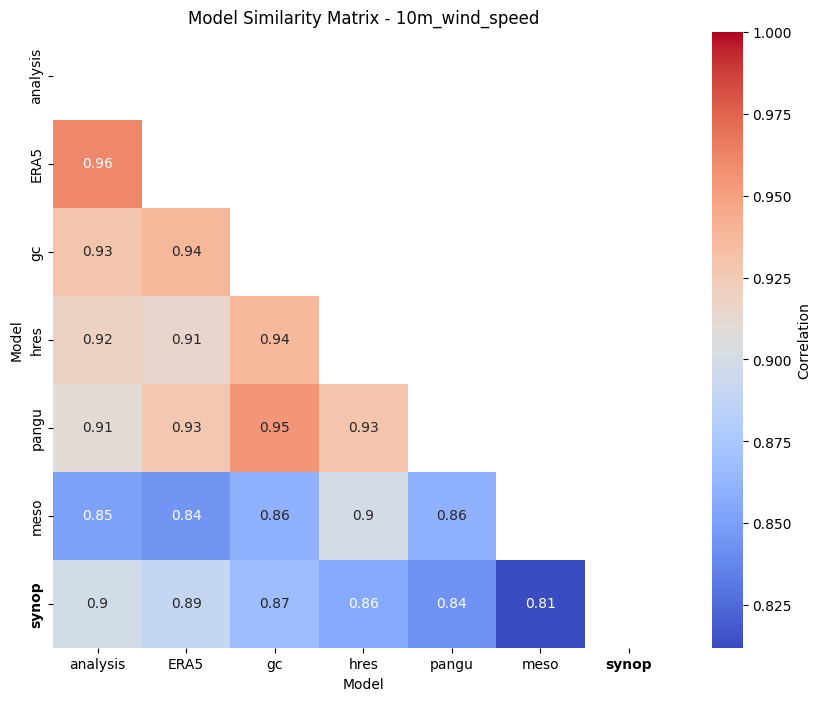

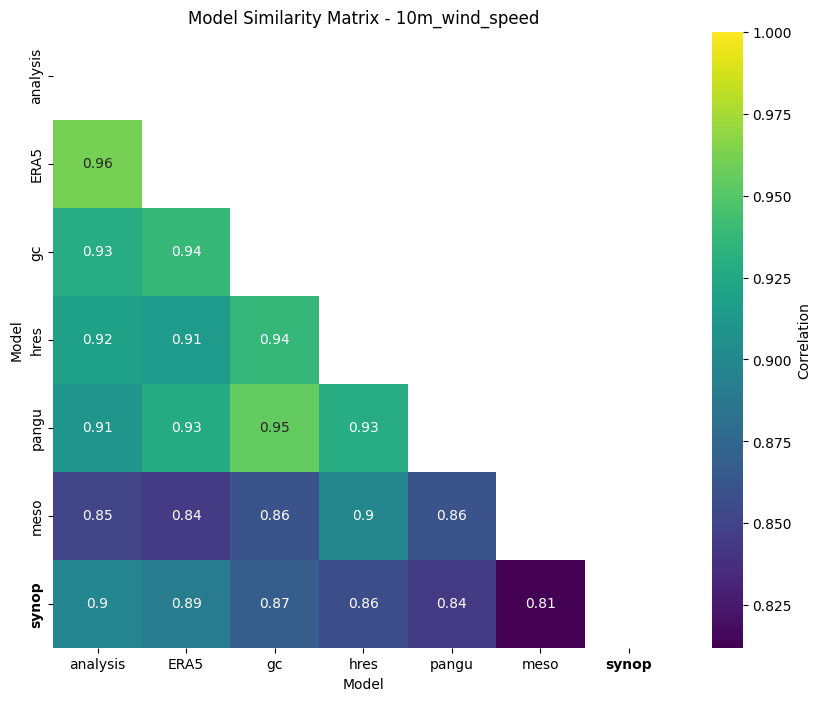

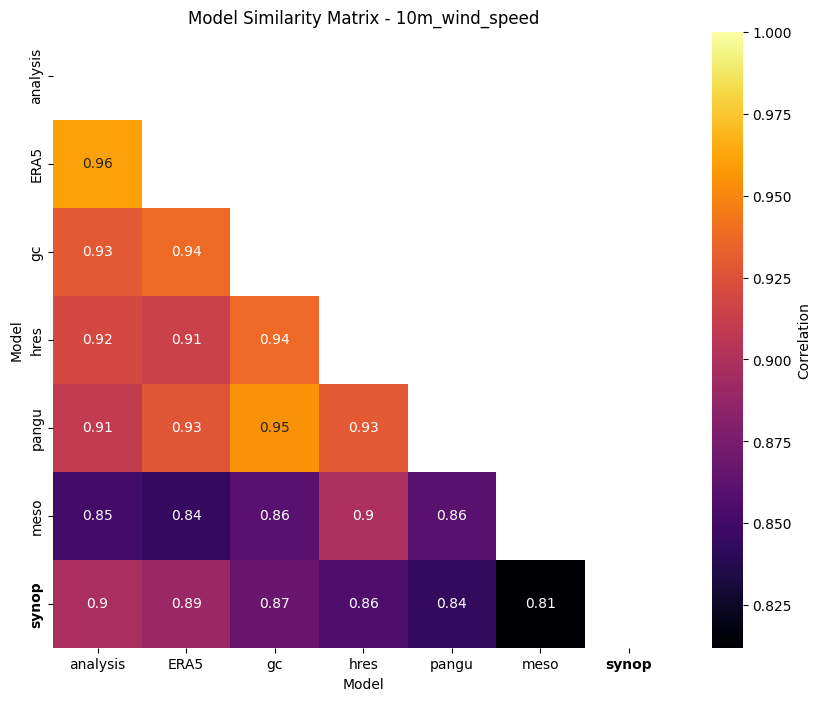

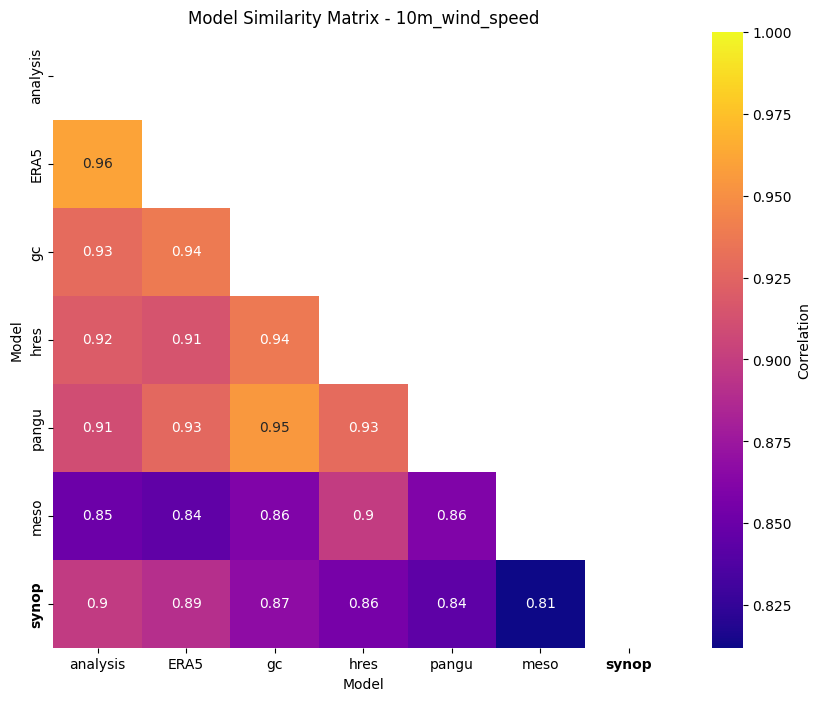

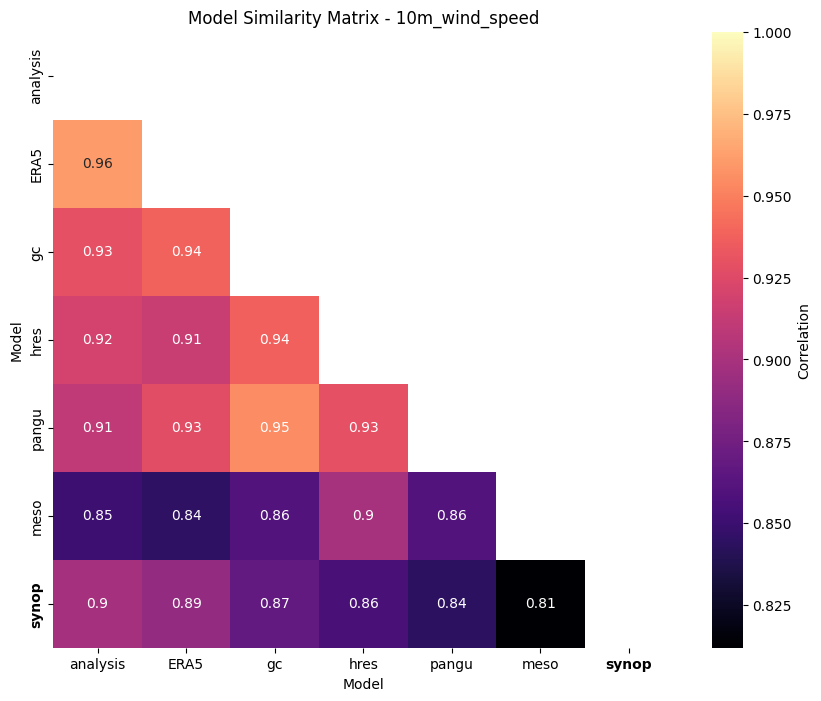

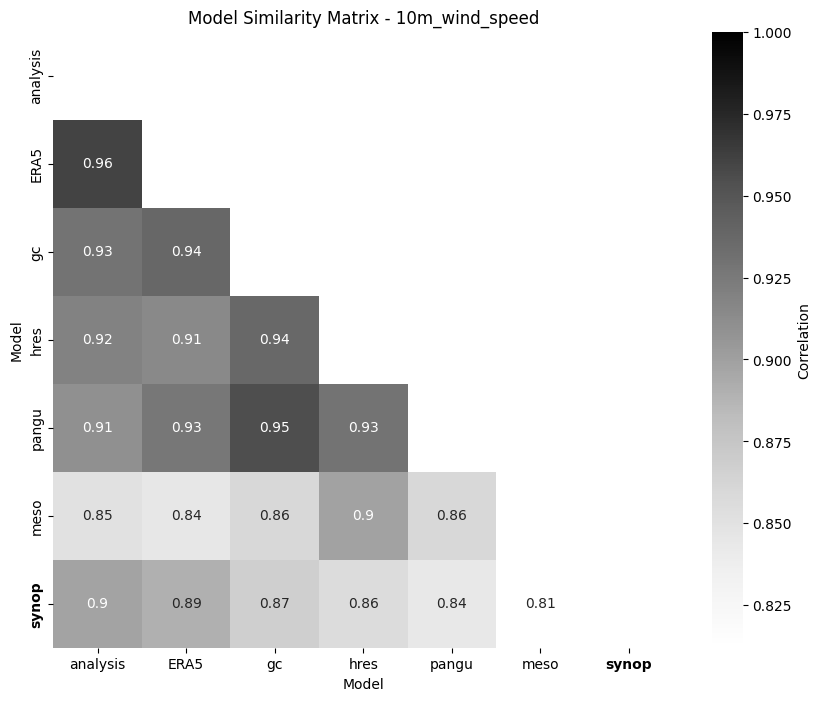

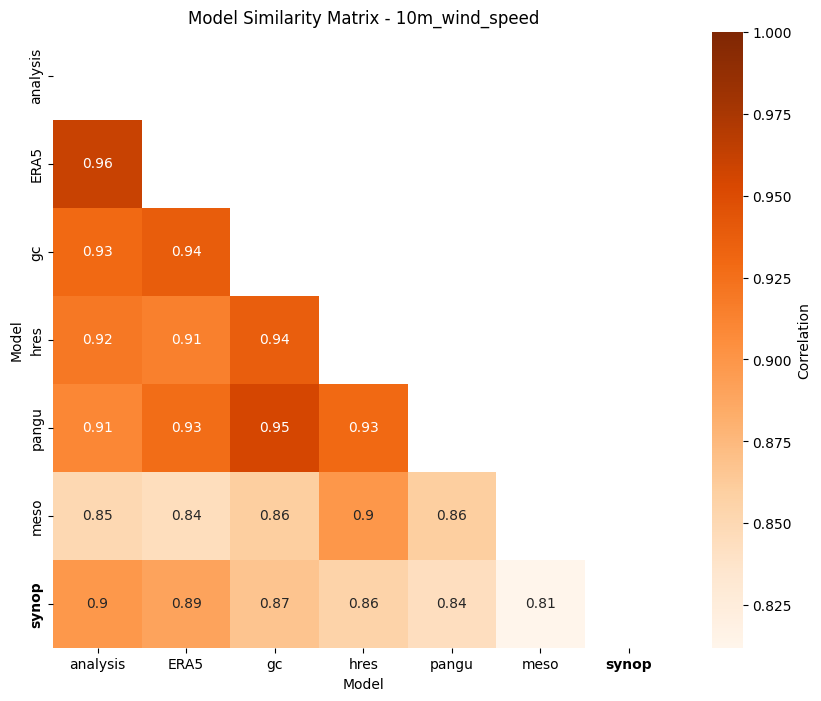

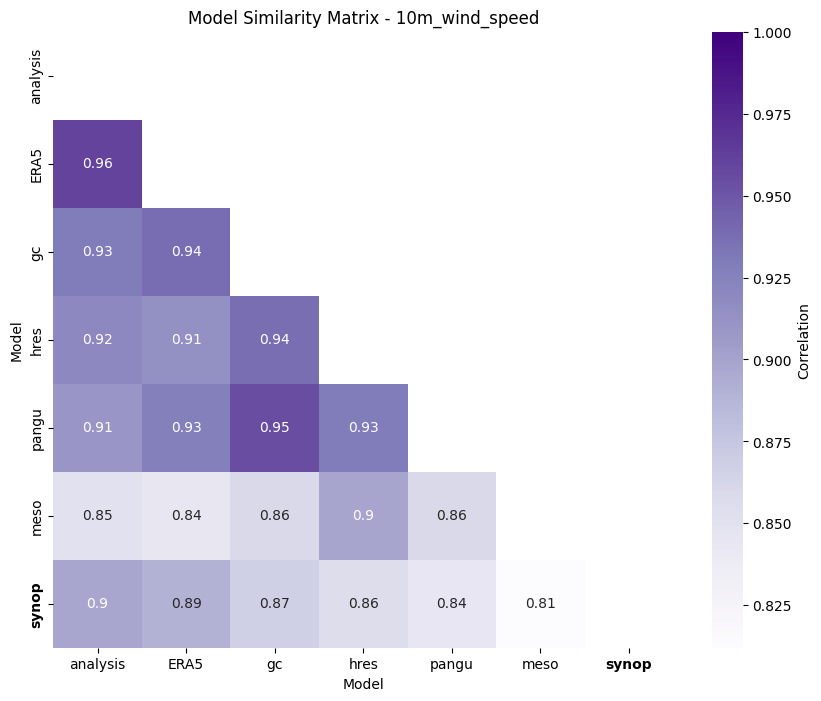

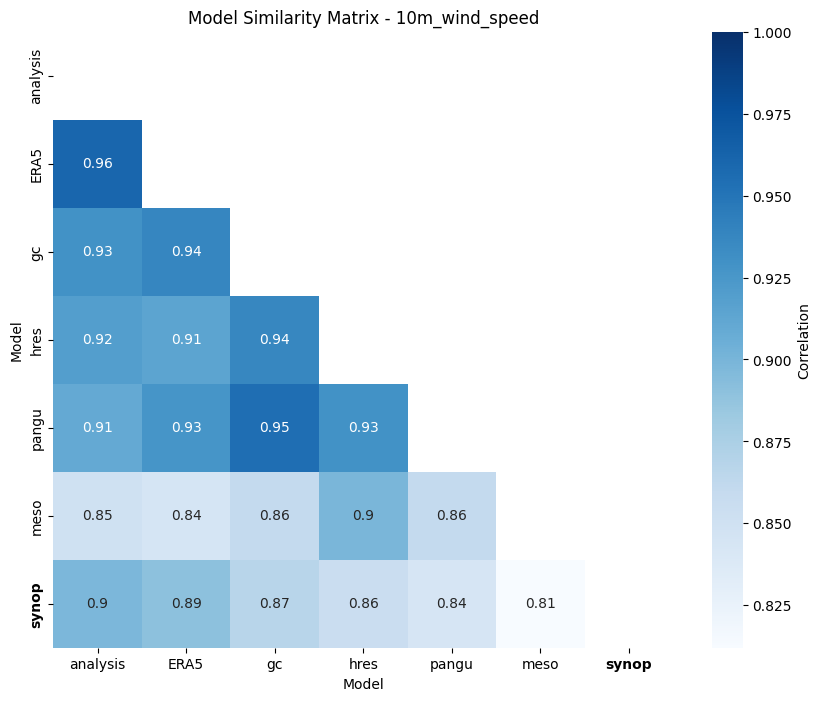

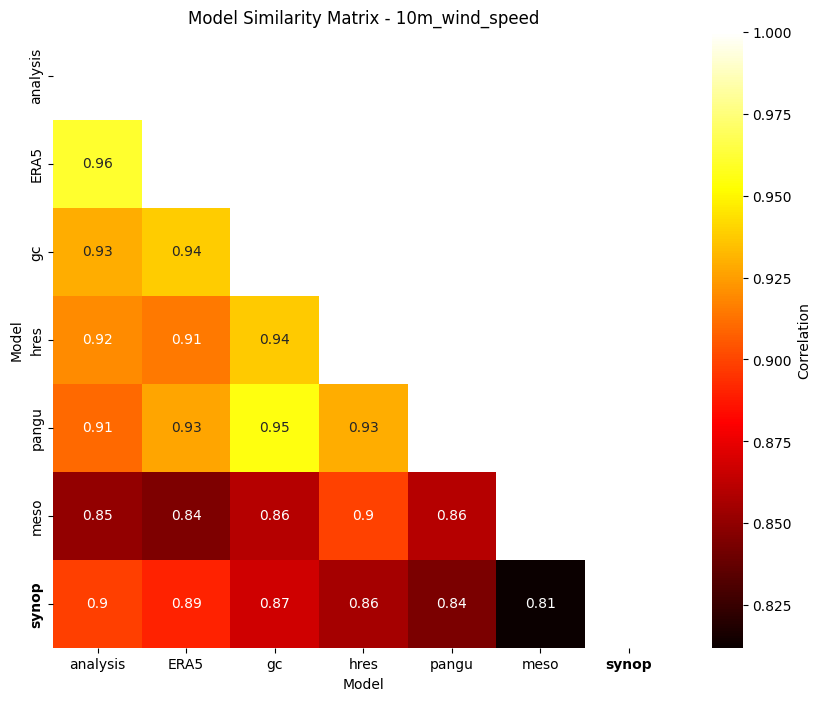

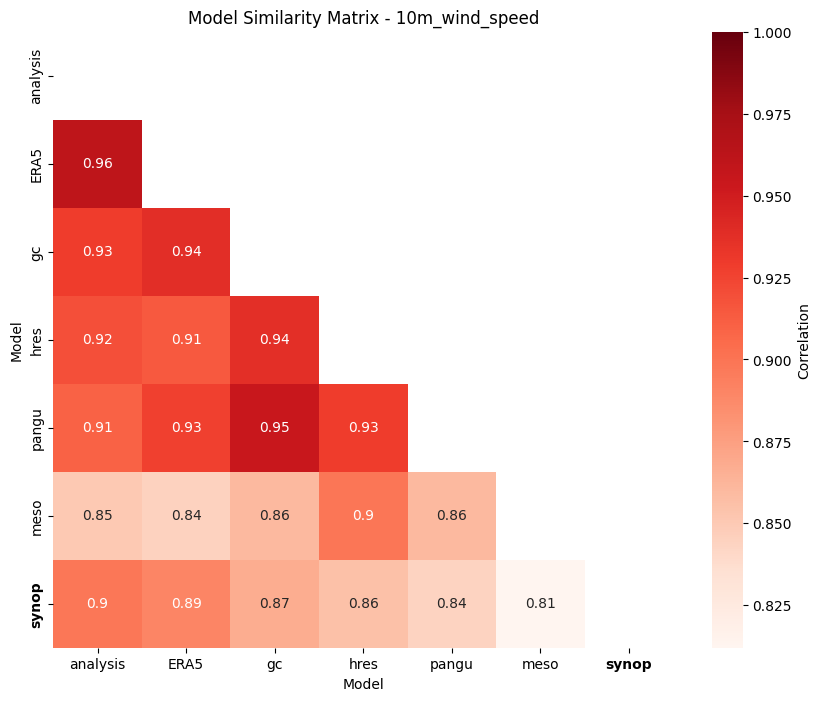

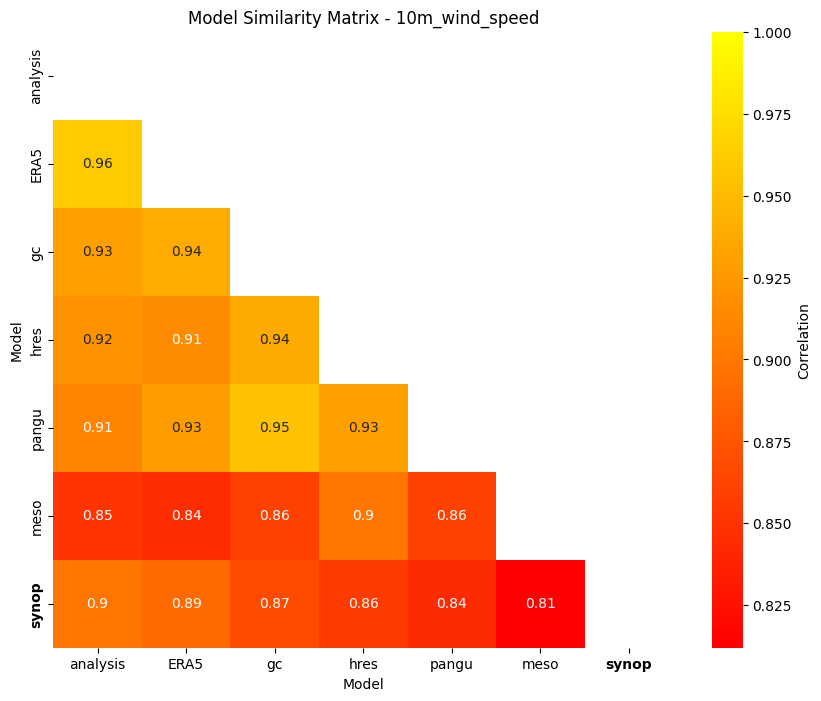

In [14]:
variables = ['10m_wind_speed']

all_suffixes = [
    'meso_pangu_ens', 
    'analysis', 
    'meso_gc_ens', 
    'hres_pangu_ens', 
    'hres', 
    'pangu', 
    'synop', 
    'meso', 
    'gc', 
    'meso_hres_ens', 
    'pangu_gc_ens', 
    'ens', 
    'ERA5', 
    'hres_pangu_gc_ens',
    'hres_gc_ens']

model_suffixes = ['analysis', 'meso', 'hres', 'pangu', 'gc', 'ERA5', 'synop']

colormaps = ['coolwarm','viridis', 'inferno', 'plasma', 'magma', 'Greys', 'Oranges','Purples', 'Blues', 'hot', 'Reds', 'autumn']

for colormap in colormaps:
    plot_intermodel_correlation(inter_model_statistics['pearson_r'], model_suffixes, variables, highlight_model='synop',colormap=colormap, save_path=None)